In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

In [2]:
# Data taken from https://www.kaggle.com/shahir/protein-data-set
# This is a protein data set retrieved from Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB).

In [3]:
df1 = pd.read_csv('pdb_data_no_dups.csv')
df2 = pd.read_csv('pdb_data_seq.csv')
df1.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [4]:
df2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
df1.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [6]:
df2.columns

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')

In [7]:
df1.shape

(141401, 14)

In [8]:
df2.shape

(467304, 5)

In [9]:
df3 = pd.merge(df1, df2, on=['structureId','macromoleculeType','residueCount'])

In [10]:
df3.shape

(471149, 16)

In [11]:
df3.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [12]:
df3.tail()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.9,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471148,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,D,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


In [13]:
df3.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
dtype: object

In [14]:
df3.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [15]:
mask = df3['macromoleculeType'] == 'Protein'

In [16]:
proteins = df3[mask]
proteins.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [17]:
proteins.shape

(346325, 16)

In [18]:
# Sanity check for protein sequences only
proteins.macromoleculeType.value_counts()

Protein    346325
Name: macromoleculeType, dtype: int64

In [19]:
proteins['sequence'].head(3)

4    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7    MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
Name: sequence, dtype: object

## Classification of Proteins: 10 Classes

In [20]:
proteins.classification.value_counts()[:35]

HYDROLASE                                  46336
TRANSFERASE                                36424
OXIDOREDUCTASE                             34322
IMMUNE SYSTEM                              15615
LYASE                                      11682
HYDROLASE/HYDROLASE INHIBITOR              11218
TRANSCRIPTION                               8919
VIRAL PROTEIN                               8495
TRANSPORT PROTEIN                           8371
VIRUS                                       6972
SIGNALING PROTEIN                           6470
ISOMERASE                                   6356
LIGASE                                      4964
MEMBRANE PROTEIN                            4891
PROTEIN BINDING                             4884
STRUCTURAL PROTEIN                          4335
CHAPERONE                                   4156
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       3548
SUGAR BINDING PROTEIN                       3474
DNA BINDING PROTEIN                         3199
PHOTOSYNTHESIS      

In [21]:
proteins.classification.value_counts()[92:122]

Hydrolase/Hydrolase inhibitor               217
ENDOCYTOSIS/EXOCYTOSIS                      217
MEMBRANE PROTEIN, TRANSPORT PROTEIN         215
ISOMERASE/ISOMERASE INHIBITOR               212
IMMUNE SYSTEM/VIRAL PROTEIN                 210
VIRUS/IMMUNE SYSTEM                         203
TRANSFERASE/ANTIBIOTIC                      202
TRANSCRIPTION REGULATION                    197
Structural Genomics, Unknown function       195
RECOMBINATION                               192
DIOXYGENASE                                 189
HYDROLASE/PEPTIDE                           188
RIBOSOMAL PROTEIN                           187
IRON STORAGE                                187
ACETYLCHOLINE-BINDING PROTEIN               180
HYDROLASE(O-GLYCOSYL)                       180
PHOSPHOTRANSFERASE                          180
Structural genomics, unknown function       166
TRANSPORT                                   160
ELECTRON TRANSPORT,PHOTOSYNTHESIS           160
ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE)

## 6 Classes of Proteins

In [24]:
mask = ((proteins.classification == 'HYDROLASE') | (proteins.classification == 'TRANSFERASE')\
      | (proteins.classification == 'OXIDOREDUCTASE') |(proteins.classification == 'IMMUNE SYSTEM')\
      | (proteins.classification == 'ISOMERASE') |(proteins.classification == 'LIGASE'))

data = proteins[mask]
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
74,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
75,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...


In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.classification)
data['type'] = le.transform(data['classification'])

/Users/scottlew/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
74,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3
75,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,0


In [27]:
data.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'type'],
      dtype='object')

In [28]:
data.classification.value_counts()

HYDROLASE         46336
TRANSFERASE       36424
OXIDOREDUCTASE    34322
IMMUNE SYSTEM     15615
ISOMERASE          6356
LIGASE             4964
Name: classification, dtype: int64

In [29]:
data.type.value_counts()

0    46336
5    36424
4    34322
1    15615
2     6356
3     4964
Name: type, dtype: int64

In [30]:
# permute/scramble/shuffle rows of the dataframe
data = data.sample(frac=1)
data.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
381537,5CBM,HYDROLASE,X-RAY DIFFRACTION,Protein,6228,2.30,705396.12,"VAPOR DIFFUSION, HANGING DROP",298.0,2.59,52.45,"40% (v/v) PEG 400, 0.1 M Tris pH 8.5, 0.2 M Li...",8.5,2015.0,F,ASEVPQVVSLDPTSIPIEYNTPIHDIKVQVYDIKGGCNVEEGLTIF...,0
354765,4W9C,LIGASE,X-RAY DIFFRACTION,Protein,1452,2.20,168490.88,"VAPOR DIFFUSION, HANGING DROP",291.0,2.41,48.97,"PEG 3350, MgOAc, Sodium cacodylate, DTT",6.3,2014.0,C,GSMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQP...,3
45459,1Q9S,TRANSFERASE,X-RAY DIFFRACTION,Protein,149,2.42,17924.29,"VAPOR DIFFUSION, HANGING DROP",293.0,2.34,47.40,"PEG MME 5000, ammonium sulphate, sodium acetat...",4.7,2003.0,A,IMRHLPYFCRGQVVRGFGRGSKQLGIPTANFPEQVVDNLPADISTG...,5


In [31]:
data.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
type                          int64
dtype: object

In [32]:
#data.isna.sum()
data.isnull().sum(axis = 0)

structureId                     0
classification                  0
experimentalTechnique           0
macromoleculeType               0
residueCount                    0
resolution                   1751
structureMolecularWeight        0
crystallizationMethod       36400
crystallizationTempK        35022
densityMatthews              6656
densityPercentSol            6610
pdbxDetails                 11157
phValue                     27454
publicationYear             24943
chainId                         1
sequence                        1
type                            0
dtype: int64

In [33]:
data.shape

(144017, 17)

In [34]:
seqs = data.sequence
print(len(seqs))

144017


In [35]:
unique_seqs = list(set(seqs))
print(len(unique_seqs))

37776


In [36]:
# remove the duplicate protein sequences
data = data.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
data = data[data['sequence'].notnull()]
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
381537,5CBM,HYDROLASE,X-RAY DIFFRACTION,Protein,6228,2.30,705396.12,"VAPOR DIFFUSION, HANGING DROP",298.0,2.59,52.45,"40% (v/v) PEG 400, 0.1 M Tris pH 8.5, 0.2 M Li...",8.5,2015.0,F,ASEVPQVVSLDPTSIPIEYNTPIHDIKVQVYDIKGGCNVEEGLTIF...,0
354765,4W9C,LIGASE,X-RAY DIFFRACTION,Protein,1452,2.20,168490.88,"VAPOR DIFFUSION, HANGING DROP",291.0,2.41,48.97,"PEG 3350, MgOAc, Sodium cacodylate, DTT",6.3,2014.0,C,GSMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQP...,3
45459,1Q9S,TRANSFERASE,X-RAY DIFFRACTION,Protein,149,2.42,17924.29,"VAPOR DIFFUSION, HANGING DROP",293.0,2.34,47.40,"PEG MME 5000, ammonium sulphate, sodium acetat...",4.7,2003.0,A,IMRHLPYFCRGQVVRGFGRGSKQLGIPTANFPEQVVDNLPADISTG...,5
372835,4ZUL,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,4104,1.76,447691.84,"VAPOR DIFFUSION, SITTING DROP",293.0,2.23,44.82,"The reservoir contained 0.1 M MgCl2, 0.1 M sod...",8.0,2015.0,B,GHMSTLLINQPQYAWLKELGLREENEGVYNGSWGGRGEVITTYCPA...,4
465795,5YKB,ISOMERASE,X-RAY DIFFRACTION,Protein,2284,2.76,260341.19,"VAPOR DIFFUSION, HANGING DROP",288.0,2.55,51.78,"7% PEG 4000, 0.2M sodium acetate trihydrate, 0...",7.0,2017.0,C,MVPTQAHPEWYKSAVFYELSVRTFQDGNGDGKGDFPGLTSRLDYLK...,2


In [37]:
data.shape

(37775, 17)

## Load additional isomerase & ligase protein sequences from csv files

In [38]:
isomerase = pd.read_csv('uniprot-isomerase.csv')

isomerase.head()

,name,sequence,classification,type
0,sp|P61615|IDI2_SACSH,MPDIVNRKVEHVEIAAFENVDGLSSSTFLNDVILVHQGFPGISFSE...,ISOMERASE,2
1,sp|Q746I8|IDI2_THET2,MNIRERKRKHLEACLEGEVAYQKTTTGLEGFRLRYQALAGLALGEV...,ISOMERASE,2
2,sp|Q8ZWV0|PGMI_PYRAE,MSQLLQDYLNWENYILRRVDFPTSYVVEGEVVRIEAMPRLYISGMG...,ISOMERASE,2
3,sp|P42126|ECI1_HUMAN,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,ISOMERASE,2
4,sp|Q9WUR2|ECI2_MOUSE,MAAVTWSRARCWCPSVLQVFRLQVAKLHLGRPTMRASQQDFENALN...,ISOMERASE,2


In [39]:
isomerase.columns = ['structureId', 'sequence', 'classification', 'type']
isomerase.head()

,structureId,sequence,classification,type
0,sp|P61615|IDI2_SACSH,MPDIVNRKVEHVEIAAFENVDGLSSSTFLNDVILVHQGFPGISFSE...,ISOMERASE,2
1,sp|Q746I8|IDI2_THET2,MNIRERKRKHLEACLEGEVAYQKTTTGLEGFRLRYQALAGLALGEV...,ISOMERASE,2
2,sp|Q8ZWV0|PGMI_PYRAE,MSQLLQDYLNWENYILRRVDFPTSYVVEGEVVRIEAMPRLYISGMG...,ISOMERASE,2
3,sp|P42126|ECI1_HUMAN,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,ISOMERASE,2
4,sp|Q9WUR2|ECI2_MOUSE,MAAVTWSRARCWCPSVLQVFRLQVAKLHLGRPTMRASQQDFENALN...,ISOMERASE,2


In [40]:
ligase = pd.read_csv('uniprot-ligase.csv')
ligase.columns = ['structureId', 'sequence', 'classification', 'type']
ligase.head()

,structureId,sequence,classification,type
0,sp|P50747|BPL1_HUMAN,MEDRLHMDNGLVPQKIVSVHLQDSTLKEVKDQVSNKQAQILEPKPE...,LIGASE,3
1,sp|O14975|S27A2_HUMAN,MLSAIYTVLAGLLFLPLLVNLCCPYFFQDIGYFLKVAAVGRRVRSY...,LIGASE,3
2,sp|P97524|S27A2_RAT,MLPVLYTGLAGLLLLPLLLTCCCPYLLQDVRFFLQLANMARQVRSY...,LIGASE,3
3,sp|O35488|S27A2_MOUSE,MLPVLYTGLAGLLLLPLLLTCCCPYLLQDVRYFLRLANMARRVRSY...,LIGASE,3
4,sp|P33121|ACSL1_HUMAN,MQAHELFRYFRMPELVDFRQYVRTLPTNTLMGFGAFAALTTFWYAT...,LIGASE,3


In [41]:
df_1 = data[['structureId', 'sequence', 'classification', 'type']]
df_1.shape

(37775, 4)

In [42]:
df_1.head()

,structureId,sequence,classification,type
381537,5CBM,ASEVPQVVSLDPTSIPIEYNTPIHDIKVQVYDIKGGCNVEEGLTIF...,HYDROLASE,0
354765,4W9C,GSMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQP...,LIGASE,3
45459,1Q9S,IMRHLPYFCRGQVVRGFGRGSKQLGIPTANFPEQVVDNLPADISTG...,TRANSFERASE,5
372835,4ZUL,GHMSTLLINQPQYAWLKELGLREENEGVYNGSWGGRGEVITTYCPA...,OXIDOREDUCTASE,4
465795,5YKB,MVPTQAHPEWYKSAVFYELSVRTFQDGNGDGKGDFPGLTSRLDYLK...,ISOMERASE,2


In [43]:
# scramble isomerase sequences in dataframe
isomerase = isomerase.sample(frac=1)
isomerase.head(3)

,structureId,sequence,classification,type
14055,sp|A0NXQ8|C3HPD_LABAI,MKITAINVFQVDLPLREGRYSWSNGNFVEVFDSTVVEIETDEGLKG...,ISOMERASE,2
4021,sp|Q9PKK3|GYRB_CHLMU,MDAQEKKYDASAITVLEGLQAVRERPGMYIGDTGVTGLHHLVYEVV...,ISOMERASE,2
14029,sp|Q05488|GMSS_CLOTT,MEKKTIVLGVIGSDCHAVGNKILDHSFTNAGFNVVNIGVLSSQEDF...,ISOMERASE,2


In [44]:
isomerase.shape

(15534, 4)

In [45]:
ligase.shape

(32792, 4)

In [46]:
df_3 = pd.concat([df_1,isomerase,ligase])
df_3.shape

(86101, 4)

In [47]:
# remove the duplicate protein sequences
df_3 = df_3.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
df_3 = df_3[df_3['sequence'].notnull()]
df_3.head()

,structureId,sequence,classification,type
381537,5CBM,ASEVPQVVSLDPTSIPIEYNTPIHDIKVQVYDIKGGCNVEEGLTIF...,HYDROLASE,0
354765,4W9C,GSMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQP...,LIGASE,3
45459,1Q9S,IMRHLPYFCRGQVVRGFGRGSKQLGIPTANFPEQVVDNLPADISTG...,TRANSFERASE,5
372835,4ZUL,GHMSTLLINQPQYAWLKELGLREENEGVYNGSWGGRGEVITTYCPA...,OXIDOREDUCTASE,4
465795,5YKB,MVPTQAHPEWYKSAVFYELSVRTFQDGNGDGKGDFPGLTSRLDYLK...,ISOMERASE,2


In [48]:
df_3.shape

(85586, 4)

## Classifier of Protein Sequences: Predict 10 Classes

## CountVectorizer: Count peptide frequency, transform the data

In [49]:
# In this case, tripeptide frequency is used for analysis
vect_ = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3,3))

## Split the data into training & test sets for classification model

In [50]:
X = vect_.fit_transform(df_3.sequence)
y = df_3.type

In [51]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(68468, 8754) (68468,)
(17118, 8754) (17118,)


In [52]:
y_test.value_counts()

3    6764
2    3413
0    2505
5    1891
4    1425
1    1120
Name: type, dtype: int64

## Logistic Regression Model

In [53]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Logistic Regression Score: {:.2f}".format(lr.score(X_test, y_test)))

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression Score: 0.82


In [54]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model

[[1833   79  118  186  120  169]
 [  58  981   13   26   10   32]
 [ 100   14 2942  187   71   99]
 [ 175   21  184 6119   89  176]
 [ 129   13   68  112  984  119]
 [ 222   47  151  190   84 1197]]


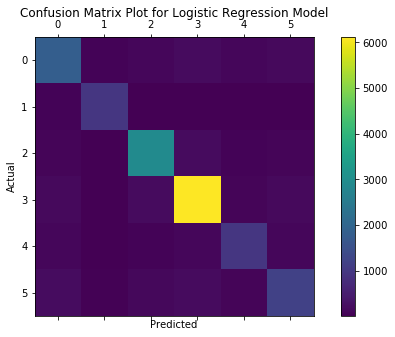

In [55]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Logistic Regression Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()